# Index Tracking with Gurobi

This Python notebook is part of the webinar [Proven Techniques for Solving Financial Problems with Gurobi](https://www.gurobi.com/events/proven-techniques-for-solving-financial-problems-with-gurobi/).

The sequence of python code will:
1. Import stock data from yahoo finance
2. Clean up the data and change format
3. Perform an index tracking experiment

## Importing Data from YFinance

- Adjusted Stock price data for SP100 constitutents 
- Data from 2010 to 2022

In [1]:
import pandas as pd
from utils.data_import import get_mkt_constitution, get_yf_data
import os
from datetime import datetime

# Options
FIRST_DATE  = "2015-01-01"
LAST_DATE   = "2022-01-01"
N_PROCESSES = 10
MKT_INDEX   = "^SP100" # ^GSPC for SP500 or ^SP100 
#MKT_INDEX   = "^GSPC"

if not os.path.exists("data"):
    os.mkdir("data")
    
# get mkt constitutents    
tickers = get_mkt_constitution(MKT_INDEX)

today = datetime.today().strftime('%Y-%m-%d')
print(f"Available Tickers for {MKT_INDEX} at {today}")
print(tickers)
print(" ")

df_prices = get_yf_data(tickers, 
                        FIRST_DATE,
                        LAST_DATE,
                        N_PROCESSES)

print("\n\nOriginal price data")
print(df_prices.head())

Fetching SP100 components
	-> got 101 tickers

Available Tickers for ^SP100 at 2023-02-23
['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT', 'AMZN', 'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'BRK.B', 'C', 'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'EXC', 'F', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KHC', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'MET', 'META', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTX', 'SBUX', 'SCHW', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS', 'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WBA', 'WFC', 'WMT', 'XOM', '^SP100']
 


Original price data
            Adj Close ticker
Date                        
2015-01-02  24.565695   AAPL
2015-01-05  23.873644   AAPL
2015-01-06  23.875889   AAPL
2015-01-07  24.2

## Cleaning and Splitting the Data

In [2]:
from sklearn.model_selection import train_test_split
import numpy  as np
import matplotlib.pyplot as plt
from utils.data_clean import clean_data

%load_ext autoreload
%autoreload 2

THRESH_VALID_DATA = 0.95 # defines where to cut stocks with missing data
PERC_SIZE_TRAIN = 0.75   # defines the size of train dataset (in %)

df_ret, df_train, df_test  = clean_data(
    df_prices, 
    MKT_INDEX,
    thresh_valid_data = THRESH_VALID_DATA,
    size_train = PERC_SIZE_TRAIN
)

df_train.to_parquet("data/ret-data-cleaned-TRAIN.parquet")
df_test.to_parquet("data/ret-data-cleaned-TEST.parquet")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176752 entries, 2015-01-02 to 2021-12-31
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Adj Close  176752 non-null  float64
 1   ticker     176752 non-null  object 
dtypes: float64(1), object(1)
memory usage: 4.0+ MB
None
Size original: (176752, 2)
Size reduced: (172774, 2)


## Unconstrained Index Tracking

$
\begin{array}{llll}
  & \min              & \frac{1}{T} \; \sum_{t = 1}^{T} \left(\sum_{i = 1}^{I} \; w_{i} \: \times \: r_{i,t} - R_{t}\right)^2 \\
  & \text{subject to} &   \sum_{i = 1}^{I} w_{i}  = 1  \\
  &                   & w_i \geq 0 \\
\end{array}
$



$
\begin{array}{lll}
& where: \\
& \\
& w_i  &: \text{Weight of asset i in index} \\
& R_{t} &: \text{Returns of tracked index (e.g. SP500) at time t} \\
& r_{i,j} &: \text{Return of asset i at time t}
\end{array}
$

In [3]:
import gurobipy as gp
import pandas as pd
import numpy as np
from random import sample, seed

seed(20220209) # reproducibility

mkt_index = "^SP100"
n_assets = 20

# data from main notebook
r_it = pd.read_parquet("data/ret-data-cleaned-TRAIN.parquet")

r_mkt = r_it[mkt_index]

r_it = r_it.drop(mkt_index, axis = 1)

tickers = list(r_it.columns)

sampled_tickers = sample(tickers, n_assets)

r_it = r_it[sampled_tickers]

print(r_it.head())

ticker            SO       ABT       AMD        MS        MA      INTC  \
Date                                                                     
2015-01-05 -0.004253  0.000222 -0.003745 -0.031258 -0.028128 -0.011276   
2015-01-06  0.012001 -0.011356 -0.011278 -0.028800 -0.002162 -0.018637   
2015-01-07  0.011055  0.008108 -0.019011  0.014277  0.015555  0.020975   
2015-01-08  0.000796  0.020554  0.011628  0.014889  0.015555  0.018601   
2015-01-09 -0.012714 -0.010508  0.007663 -0.016271 -0.012744  0.001908   

ticker           SPG        GS       LLY      MDLZ        PG       TMO  \
Date                                                                     
2015-01-05  0.004101 -0.031223 -0.009848 -0.014950 -0.004755 -0.013737   
2015-01-06  0.027834 -0.020229  0.005046 -0.006898 -0.004555 -0.009339   
2015-01-07  0.018402  0.014902 -0.007028  0.031397  0.005245  0.029957   
2015-01-08 -0.001438  0.015966  0.023689  0.012662  0.011436  0.010393   
2015-01-09  0.010539 -0.015347 -0.013

# Setup opt problem and solve

In [5]:
# Create an empty model
m = gp.Model('gurobi_index_tracking')

# PARAMETERS 

# w_i: the i_th stock gets a weight w_i
w = pd.Series(m.addVars(sampled_tickers, 
                         lb = 0,
                         ub = 1,
                         vtype = gp.GRB.CONTINUOUS), 
               index=sampled_tickers)

# CONSTRAINTS

# sum(w_i) = 1: portfolio budget constrain (long only)
m.addConstr(w.sum() == 1, 'port_budget')

m.update()

# eps_t = R_{i,t}*w - R_{M,t}
my_error = r_it.dot(w) - r_mkt

# set objective function
m.setObjective(
    gp.quicksum(my_error.pow(2)), 
    gp.GRB.MINIMIZE)     

# Optimize model
m.setParam('OutputFlag', 0)
m.optimize()

w_hat  = [i.X for i in m.getVars()]

print(f"Solution:") 

for i, i_ticker in enumerate(sampled_tickers):
    print(f"{i_ticker}:\t {w_hat[i]*100:.2f}%")

# check constraints
print(f"\nchecking constraints:")
print(f"sum(w) = {np.sum(w_hat)}")

Solution:
SO:	 3.69%
ABT:	 4.85%
AMD:	 0.43%
MS:	 0.00%
MA:	 13.00%
INTC:	 7.69%
SPG:	 2.79%
GS:	 7.41%
LLY:	 6.82%
MDLZ:	 3.44%
PG:	 10.72%
TMO:	 6.61%
USB:	 4.29%
FDX:	 5.46%
MO:	 4.48%
AVGO:	 2.90%
BLK:	 2.22%
HON:	 6.98%
GM:	 2.83%
BAC:	 3.39%

checking constraints:
sum(w) = 0.9999999999999842


Index(['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT',
       'AMZN', 'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'C',
       'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO',
       'CVS', 'CVX', 'DHR', 'DIS', 'DUK', 'EMR', 'EXC', 'F', 'FDX', 'GD', 'GE',
       'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ',
       'JPM', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT',
       'MET', 'META', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE',
       'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'QCOM', 'RTX', 'SBUX', 'SCHW',
       'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS', 'TSLA', 'TXN', 'UNH', 'UNP',
       'UPS', 'USB', 'V', 'VZ', 'WBA', 'WFC', 'WMT', 'XOM', '^SP100'],
      dtype='object', name='ticker')
['SO', 'ABT', 'AMD', 'MS', 'MA', 'INTC', 'SPG', 'GS', 'LLY', 'MDLZ', 'PG', 'TMO', 'USB', 'FDX', 'MO', 'AVGO', 'BLK', 'HON', 'GM', 'BAC']


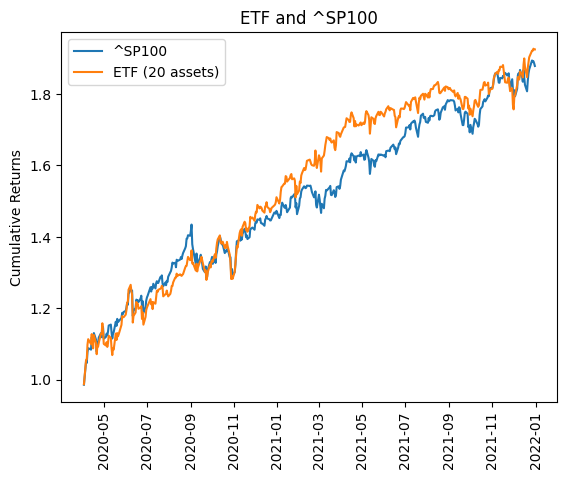

In [6]:
# check out of sample plot
import matplotlib.pyplot as plt

df_test = pd.read_parquet("data/ret-data-cleaned-TEST.parquet")

print(df_test.columns)
print(sampled_tickers)
df_test_mkt = df_test[mkt_index]

r_hat = df_test[sampled_tickers].dot(w_hat)

cumret_r = np.cumprod(1+ r_hat)
cumret_mkt = np.cumprod(1+ df_test_mkt)

fig, ax = plt.subplots()
ax.plot(cumret_mkt.index,
        cumret_mkt, 
       label = mkt_index)

ax.plot(cumret_r.index,
        cumret_r,
       label = f"ETF ({n_assets} assets)")

ax.legend()
ax.set_title(f'ETF and {mkt_index}')
ax.set_xlabel('')
ax.set_ylabel('Cumulative Returns')

plt.xticks(rotation = 90)

plt.show()

## Constrained Index Tracking

$
\begin{array}{llll}
  & \min              & \frac{1}{T} \; \sum_{t = 1}^{T} \left(\sum_{i = 1}^{I} \; w_{i} \: \times \: r_{i,t} - R_{t}\right)^2 \\
  & \text{subject to} &   \sum_{i = 1}^{I} w_{i}  = 1  \\
  &                   &   \sum_{i = 1}^{I} z_{i} \leq K \\
  &                   & w_i \geq 0 \\
  &                   & z_i \in {0, 1}
\end{array}
$

  

$
\begin{array}{lllll}
& where: \\
& \\
& w_i  &: \text{Weight of asset i in index} \\
& z_i &: \text{Binary variable (0, 1) that decides wheter asset i is in portfolio} \\
& R_{t} &: \text{Returns of tracked index (e.g. SP500) at time t} \\
& r_{i,j} &: \text{Return of asset i at time t}
\end{array}
$

In [7]:
# Create an empty model
m = gp.Model('gurobi_index_tracking')

# PARAMETERS 

max_assets = 10

# w_i: the i_th stock gets a weight w_i
w = pd.Series(m.addVars(sampled_tickers, 
                         lb = 0,
                         ub = 0.2,
                         vtype = gp.GRB.CONTINUOUS), 
               index=sampled_tickers)

# [NEW] z_i: the i_th stock gets a binary z_i
z = pd.Series(m.addVars(sampled_tickers,
                        vtype = gp.GRB.BINARY),
                index=sampled_tickers)

# CONSTRAINTS

# sum(w_i) = 1: portfolio budget constrain (long only)
m.addConstr(w.sum() == 1, 'port_budget')

# [NEW]  w_i <= z_i: restrictions of values of w_i so take it chose particular tickers
for i_ticker in sampled_tickers:
    m.addConstr(w[i_ticker] <= z[i_ticker], 
                f'dummy_restriction_{i_ticker}')

# [NEW] sum(z_i) <= max_assets: number of assets constraint
m.addConstr(z.sum() <= max_assets, 'max_assets_restriction')

m.update()

# eps_t = R_{i,t}*w - R_{M,t}
my_error = r_it.dot(w) - r_mkt

# set objective function
m.setObjective(
    gp.quicksum(my_error.pow(2)), 
    gp.GRB.MINIMIZE)     

# Optimize model
m.setParam('OutputFlag', 0)
m.setParam('TimeLimit', 60*5) # in secs
#m.setParam('MIPGap', 0.05) # in secs
m.optimize()

params = [i.X for i in m.getVars()]

n_assets = len(sampled_tickers)
w_hat = params[0:n_assets]
z_hat = params[n_assets:]
MIPGap = m.getAttr('MIPGap')
status = m.getAttr("Status")

print(f"Solution for w:") 

for i, i_ticker in enumerate(sampled_tickers):
    print(f"{i_ticker}:\t {w_hat[i]*100:.2f}%")

# check constraints
print(f"\nchecking constraints:")
print(f"sum(w) = {np.sum(w_hat)}")
print(f"sum(z) = {np.sum(z_hat)}")
print(f"w <= z = {w_hat <= z_hat}")
print(f"MIPGap={MIPGap}")
print(f"Status={status}")

Solution for w:
SO:	 6.86%
ABT:	 0.00%
AMD:	 0.00%
MS:	 0.00%
MA:	 14.92%
INTC:	 7.93%
SPG:	 0.00%
GS:	 14.51%
LLY:	 8.73%
MDLZ:	 0.00%
PG:	 14.13%
TMO:	 8.72%
USB:	 0.00%
FDX:	 7.64%
MO:	 0.00%
AVGO:	 3.98%
BLK:	 0.00%
HON:	 12.57%
GM:	 0.00%
BAC:	 0.00%

checking constraints:
sum(w) = 0.9999999999999998
sum(z) = 10.0
w <= z = True
MIPGap=0.0
Status=2


Index(['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT',
       'AMZN', 'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'C',
       'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO',
       'CVS', 'CVX', 'DHR', 'DIS', 'DUK', 'EMR', 'EXC', 'F', 'FDX', 'GD', 'GE',
       'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ',
       'JPM', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT',
       'MET', 'META', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE',
       'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'QCOM', 'RTX', 'SBUX', 'SCHW',
       'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS', 'TSLA', 'TXN', 'UNH', 'UNP',
       'UPS', 'USB', 'V', 'VZ', 'WBA', 'WFC', 'WMT', 'XOM', '^SP100'],
      dtype='object', name='ticker')
['SO', 'ABT', 'AMD', 'MS', 'MA', 'INTC', 'SPG', 'GS', 'LLY', 'MDLZ', 'PG', 'TMO', 'USB', 'FDX', 'MO', 'AVGO', 'BLK', 'HON', 'GM', 'BAC']


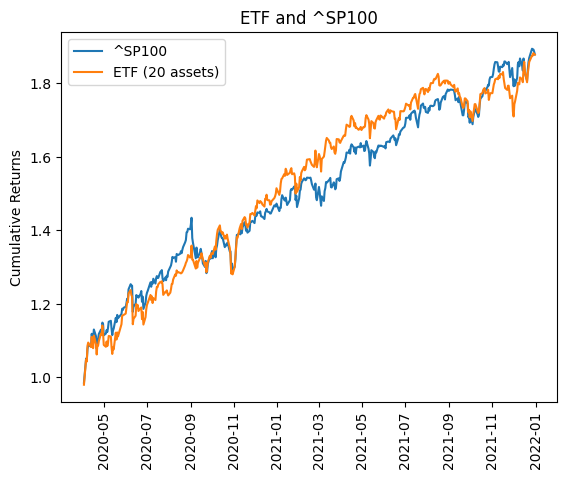

In [8]:
# check out of sample plot
import matplotlib.pyplot as plt

df_test = pd.read_parquet("data/ret-data-cleaned-TEST.parquet")

print(df_test.columns)
print(sampled_tickers)
df_test_mkt = df_test[mkt_index]

r_hat = df_test[sampled_tickers].dot(w_hat)

cumret_r = np.cumprod(1+ r_hat)
cumret_mkt = np.cumprod(1+ df_test_mkt)

fig, ax = plt.subplots()
ax.plot(cumret_mkt.index,
        cumret_mkt, 
       label = mkt_index)

ax.plot(cumret_r.index,
        cumret_r,
       label = f"ETF ({n_assets} assets)")

ax.legend()
ax.set_title(f'ETF and {mkt_index}')
ax.set_xlabel('')
ax.set_ylabel('Cumulative Returns')

plt.xticks(rotation = 90)

plt.show()